### 运行版本

In [1]:
import sys

sys.version

'3.8.13 (default, Mar 28 2022, 06:59:08) [MSC v.1916 64 bit (AMD64)]'

In [2]:
import tensorflow

tensorflow.__version__

'2.6.0'

In [3]:
import torch

torch.__version__

'1.10.1'

In [4]:
# !python -m deepxde.backend.set_default_backend tensorflow.compat.v1

In [5]:
import deepxde

deepxde.__version__

Using backend: tensorflow.compat.v1



Instructions for updating:
non-resource variables are not supported in the long term



'1.1.3'

代码来源： https://deepxde.readthedocs.io/en/latest/demos/pinn_forward/poisson.1d.dirichletperiodic.html

# Poisson方程

## 2.1 基本定义

记 $\large x=(x_1,\cdots,x_n) \in \mathbb{R}^n, u=u(x), 拉普拉斯算子 \Delta u = \sum^n_{i=1} u_{x_i x_i} $，Laplace方程又称为“**位势方程**”, 最有用的PDE之一无疑。包括Laplace方程
$$
\large \Delta u = 0 \tag{2.1}
$$
以及Poisson方程
$$
\large - \Delta u = f.  \tag{2.2}
$$
在上面两个方程中，$x \in U$ 且未知量为 $\large u:\bar{U} \to \mathbb{R}, u = u(x)$，这里 $u \subset \mathbb{R}^n$ 是开集. 而在第二个方程中 $f:U \to \mathbb{R}$ 也是给定的。


## 2.2 问题设置
- 具有狄利克雷/周期边界条件的一维泊松方程

我们将求解一个泊松方程：$$\large −Δu=π^2sin(πx),x∈[−1,1], \tag{2.3}$$

在右边界上具有周期性边界条件: $$u(0)=u(1).$$

和左边界上的狄利克雷边界条件: $$u(−1)=0.$$ 

确切的解决方案是 $$\large u(x)=sin(πx).$$ 

mathematica求解代码
```mathematica
DSolve[{-D[u[x], {x, 2}] == Pi^2 Sin[Pi x], u[0] == u[1], u[-1] == 0}, u[x], {x}]
```

In [1]:
# 首先，导入 DeepXDE 和 TensorFlow ( `tf`) 模块：

import deepxde as dde
import numpy as np
from deepxde.backend import tf

Using backend: tensorflow.compat.v1



Instructions for updating:
non-resource variables are not supported in the long term



定义泊松方程：$\large −Δu=π^2sin(πx),x∈[−1,1]$

In [2]:
# 几何区域
geom = dde.geometry.Interval(-1, 1)


# 偏微分方程
def pde(x, y):
    """
    x: network input,  x-coordinate
    y: network output, the solution u(x),but here we use y as the name of the variable.
    return: −Δ𝑢 -π^2 𝑠𝑖𝑛(π𝑥)
    """
    dy_xx = dde.grad.hessian(y, x)
    return -dy_xx - np.pi ** 2 * tf.sin(np.pi * x)

定义边界条件

在右边界上具有周期性边界条件: $u(0)=u(1).$

和左边界上的狄利克雷边界条件: $u(−1)=0.$

In [3]:
def boundary_r(x, on_boundary):
    return on_boundary and np.isclose(x[0], 1)

def boundary_l(x, on_boundary):
    return on_boundary and np.isclose(x[0], -1)

# define a function to return the value of u(x) for the points x on the Dirichlet boundary.
def func(x):
    return np.sin(np.pi * x)


# 狄利克雷边界条件
bc1 = dde.DirichletBC(geom, func, boundary_l) 
# 周期性边界条件
bc2 = dde.PeriodicBC(geom, 0, boundary_r) 

In [4]:
data = dde.data.PDE(geom, pde, [bc1, bc2], 16, 2, solution=func, num_test=100)

# 数字 16 是在域内采样的训练残差点数，数字 2 是在边界上采样的训练点数。
# 参数`solution=func`是计算我们解决方案误差的参考解决方案，如果我们没有参考解决方案，可以忽略。
# 我们使用 100 个残差点来测试 PDE 残差。

G:\Anaconda3\envs\py3.8\lib\site-packages\skopt\sampler\sobol.py:246: UserWarning: The balance properties of Sobol' points require n to be a power of 2. 0 points have been previously generated, then: n=0+18=18. 
  warnings.warn("The balance properties of Sobol' points require "


net

In [5]:
# 深度为 4（即 3 个隐藏层）和宽度为 50 的全连接神经网络
layer_size = [1] + [50] * 3 + [1]
activation = "tanh"
initializer = "Glorot uniform"
net = dde.nn.FNN(layer_size, activation, initializer)

model

构建一个`Model`并选择优化器和学习率,L2相对误差作为训练期间的指标

In [6]:
model = dde.Model(data, net)
model.compile("adam", lr=2e-5, metrics=["l2 relative error"])

Compiling model...
Building feed-forward neural network...
'build' took 0.070400 s



G:\Anaconda3\envs\py3.8\lib\site-packages\keras\legacy_tf_layers\core.py:236: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  warnings.warn('`tf.layers.dense` is deprecated and '
G:\Anaconda3\envs\py3.8\lib\site-packages\keras\engine\base_layer_v1.py:1676: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


'compile' took 3.733325 s



model.train

In [7]:
losshistory, train_state = model.train(epochs=80000)

Initializing variables...
Training model...

Step      Train loss                        Test loss                         Test metric   
0         [4.70e+01, 3.07e-02, 1.23e-01]    [4.95e+01, 3.07e-02, 1.23e-01]    [1.12e+00]    
1000      [2.38e+01, 7.10e-04, 4.92e-01]    [2.53e+01, 7.10e-04, 4.92e-01]    [7.44e-01]    
2000      [5.55e+00, 1.68e-03, 2.44e-01]    [5.62e+00, 1.68e-03, 2.44e-01]    [3.69e-01]    
3000      [1.37e+00, 2.62e-04, 1.05e-02]    [1.06e+00, 2.62e-04, 1.05e-02]    [7.13e-02]    
4000      [6.18e-01, 1.36e-05, 3.19e-03]    [3.47e-01, 1.36e-05, 3.19e-03]    [7.91e-02]    
5000      [3.45e-01, 2.77e-05, 7.27e-04]    [1.80e-01, 2.77e-05, 7.27e-04]    [3.95e-02]    
6000      [1.38e-01, 5.79e-06, 2.14e-04]    [6.17e-02, 5.79e-06, 2.14e-04]    [1.23e-02]    
7000      [6.79e-02, 2.61e-07, 4.54e-05]    [4.75e-02, 2.61e-07, 4.54e-05]    [1.55e-02]    
8000      [3.04e-02, 6.21e-07, 2.05e-05]    [2.23e-02, 6.21e-07, 2.05e-05]    [1.03e-02]    
9000      [9.52e-03, 5.17

plot

In [8]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

def plot_loss_history(loss_history):
    """Plot the training and testing loss history.

    Note:
        You need to call ``plt.show()`` to show the figure.

    Args:
        loss_history: ``LossHistory`` instance. The first variable returned from
            ``Model.train()``.
    """
    loss_train = np.sum(loss_history.loss_train, axis=1)
    loss_test = np.sum(loss_history.loss_test, axis=1)

    plt.figure(figsize=(10, 8))
    plt.semilogy(loss_history.steps, loss_train, label="Train loss")
    plt.semilogy(loss_history.steps, loss_test, label="Test loss")
    for i in range(len(loss_history.metrics_test[0])):
        plt.semilogy(
            loss_history.steps,
            np.array(loss_history.metrics_test)[:, i],
            label="Test metric",
        )
    plt.xlabel("Steps")
    plt.ylabel("loss")
    plt.legend()
    plt.show()

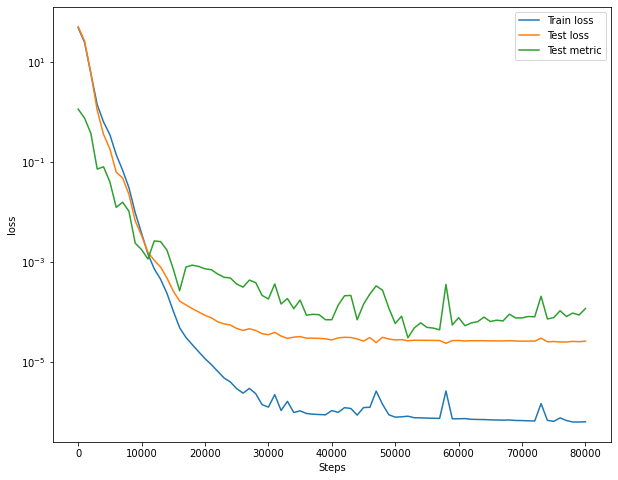

In [9]:
plot_loss_history(losshistory)

In [14]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.mplot3d import Axes3D

def _pack_data(train_state):
    def merge_values(values):
        if values is None:
            return None
        return np.hstack(values) if isinstance(values, (list, tuple)) else values

    y_train = merge_values(train_state.y_train)
    y_test = merge_values(train_state.y_test)
    best_y = merge_values(train_state.best_y)
    best_ystd = merge_values(train_state.best_ystd)
    return y_train, y_test, best_y, best_ystd

def plot_best_state(train_state):
    """Plot the best result of the smallest training loss.

    This function only works for 1D and 2D problems. For other problems and to better
    customize the figure, use ``save_best_state()``.

    Note:
        You need to call ``plt.show()`` to show the figure.

    Args:
        train_state: ``TrainState`` instance. The second variable returned from
            ``Model.train()``.
    """
    if isinstance(train_state.X_train, (list, tuple)):
        print(
            "Error: The network has multiple inputs, and plotting such result han't been implemented."
        )
        return

    y_train, y_test, best_y, best_ystd = _pack_data(train_state)
    y_dim = best_y.shape[1]

    # Regression plot
    # 1D
    if train_state.X_test.shape[1] == 1:
        idx = np.argsort(train_state.X_test[:, 0])
        X = train_state.X_test[idx, 0]
        plt.figure(figsize=(10, 6))
        for i in range(y_dim):
            if y_train is not None:
                plt.plot(train_state.X_train[:, 0], y_train[:, i], "ok", label="Train")
            if y_test is not None:
                plt.plot(X, y_test[idx, i], "-k", label="True")
            plt.plot(X, best_y[idx, i], "--r", label="Prediction")
            if best_ystd is not None:
                plt.plot(
                    X, best_y[idx, i] + 2 * best_ystd[idx, i], "-b", label="95% CI"
                )
                plt.plot(X, best_y[idx, i] - 2 * best_ystd[idx, i], "-b")
        plt.xlabel("x")
        plt.ylabel("y")
        plt.legend()
    # 2D
    elif train_state.X_test.shape[1] == 2:
        for i in range(y_dim):
            plt.figure(figsize=(20, 12))
            ax = plt.axes(projection=Axes3D.name)
            ax.plot3D(
                train_state.X_test[:, 0],
                train_state.X_test[:, 1],
                best_y[:, i],
                ".",
            )
            ax.set_xlabel("$x_1$")
            ax.set_ylabel("$x_2$")
            ax.set_zlabel("$y_{}$".format(i + 1))

    plt.show()


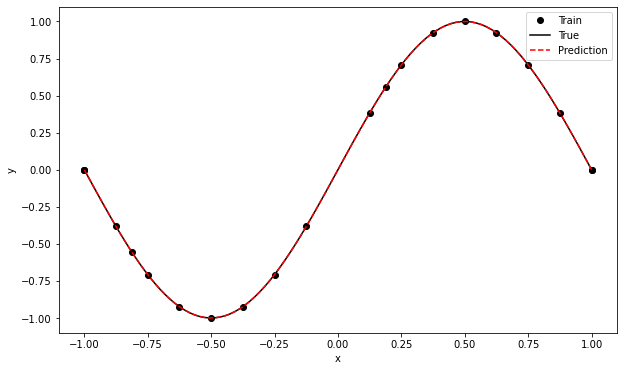

In [15]:
plot_best_state(train_state)

In [13]:
# dde.saveplot(losshistory, train_state, issave=True, isplot=True)